In [1]:
import os
import math
import time
import numpy as np
import pandas as pd
from scipy import stats
import scipy.io as sio
import statsmodels
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def zscore(data, axis):
    data -= data.mean(axis=axis, keepdims=True)
    data /= data.std(axis=axis, keepdims=True)
    return np.nan_to_num(data, copy=False)

def correlation(matrix1, matrix2):
    d1 = matrix1.shape[-1]
    d2 = matrix2.shape[-1]

    assert d1 == d2
    assert matrix1.ndim <= 2
    assert matrix2.ndim <= 2
    
    matrix1 = zscore(matrix1.astype(float), matrix1.ndim - 1) / np.sqrt(d1)
    matrix2 = zscore(matrix2.astype(float), matrix2.ndim - 1) / np.sqrt(d2)
    
    if matrix1.ndim >= matrix2.ndim:
        return np.dot(matrix1, matrix2.T)
    else:
        return np.dot(matrix2, matrix1.T)

In [3]:
filepath = "/Users/xli77/Documents/MISA-pytorch/figures/ISBI2022/brain_age"
X_partial = sio.loadmat(os.path.join(filepath, "partialX.mat"))["partialX"]
X_ind = np.squeeze(sio.loadmat(os.path.join(filepath, "orderX.mat"))["orderX"])

In [12]:
data=sio.loadmat("/Users/xli77/Documents/MISA/results/SIVA/fixedSubspace/um2mm/subspace_struct_2222211/ummm_neuroimaging_Y.mat")
y2=np.squeeze(data['Y2'])
X = np.concatenate((y2[0],y2[1][:-2,:],np.expand_dims(y2[1][-1,:],axis=0)),axis=0).T
Y = np.load(os.path.join(filepath, "Y.npy")) # actual age, Nsub x 1
Y2 = np.load(os.path.join(filepath, "Y2.npy")) # actual age, Nsub x 5

In [13]:
print(np.mean(Y), np.std(Y))

62.09494324045408 7.315716612287679


In [5]:
reversed_sorted_index = list(X_ind-1)
X_new = np.copy(X_partial)

n_sub = X_new.shape[0]
n_mode = X_new.shape[1]

Y2_new = sio.loadmat(os.path.join(filepath, "confY.mat"))["confY"]
Y_new = Y2_new[:, 0]

# change sign
for i in range(n_mode):
    if np.corrcoef(X[:, i], Y)[0,1]>0:
        X[:,i] = -X[:,i]
        X_new[:,i] = -X_new[:,i]

X_sorted = np.copy(X)

In [6]:
# equation 1
beta1 = np.linalg.inv( X_new.T @ X_new ) @ X_new.T @ Y_new
delta1 = X_new @ beta1 - Y_new
print('delta 1: ' + str(round(np.mean(np.abs(delta1)), 2)))

beta2 = np.linalg.inv( Y2_new.T @ Y2_new ) @ Y2_new.T @ delta1
delta2 = delta1 - Y2_new @ beta2
# all in one model
error = np.mean(np.abs(delta2))
print("delta 2: " + str(round(error, 2)))
# np.std(delta2-(Y-np.mean(Y)), ddof=1)
# np.std(X_new @ beta1, ddof=1)

delta 1: 4.03
delta 2: 2.83


In [7]:
model = sm.OLS(Y_new, X_new).fit()
# print(model.summary())

p_values = model.pvalues
log_p_values = np.zeros(p_values.shape) 
for i in range(log_p_values.shape[0]):
    log_p_values[i] = -math.log10(p_values[i])

print(np.where(log_p_values > -math.log10(0.05/n_mode)))
print(np.where(p_values < 0.05/n_mode))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 11, 12, 14]),)
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 11, 12, 14]),)


In [8]:
i = 1
X_new_modality = X_new[:, :12]
beta1_modality = np.linalg.inv( X_new_modality.T @ X_new_modality ) @ X_new_modality.T @ Y_new
delta1_modality = X_new_modality @ beta1_modality - Y_new
print(f"modality: {i}; delta 1: {round(np.mean(np.abs(delta1_modality)), 2)}")

beta2_modality = np.linalg.inv( Y2_new.T @ Y2_new ) @ Y2_new.T @ delta1_modality
delta2_modality = delta1_modality - Y2_new @ beta2_modality
error = np.mean(np.abs(delta2_modality))
print(f"modality: {i}; delta 2: {round(error, 2)}")

# all in one model for each modality
i = 2
X_new_modality = X_new[:, 12:]
beta1_modality = np.linalg.inv( X_new_modality.T @ X_new_modality ) @ X_new_modality.T @ Y_new
delta1_modality = X_new_modality @ beta1_modality - Y_new
print(f"modality: {i}; delta 1: {round(np.mean(np.abs(delta1_modality)), 2)}")

beta2_modality = np.linalg.inv( Y2_new.T @ Y2_new ) @ Y2_new.T @ delta1_modality
delta2_modality = delta1_modality - Y2_new @ beta2_modality
error = np.mean(np.abs(delta2_modality))
print(f"modality: {i}; delta 2: {round(error, 2)}")

modality: 1; delta 1: 4.09
modality: 1; delta 2: 2.83
modality: 2; delta 1: 5.74
modality: 2; delta 2: 1.82


In [9]:
beta1i = np.copy(beta1)
beta2i = np.zeros( (Y2_new.shape[1], n_mode) )
delta1i = np.zeros((n_sub, n_mode))
delta2i = np.zeros((n_sub, n_mode))
delta2i_mae = np.zeros(n_mode)
a = 0 # 1 / n_mode

# Yb1 = X_new * beta1.T a simple way to get delta1

for i in range(n_mode):
    # x = np.expand_dims( X_new[:,i], axis=1 )
    # beta1i[i] = np.linalg.inv( x.T @ x ) @ x.T @ Y_new
    delta1i[:, i] = X_new[:,i] * beta1i[i] - a * Y_new

    # brain age paper uses PCA of Y2
    Y2_new_demean = Y2_new - np.mean(Y2_new, axis=0)
    beta2i[:, i] = np.linalg.inv( Y2_new_demean.T @ Y2_new_demean ) @ Y2_new_demean.T @ delta1i[:, i]
    delta2i[:, i] =  delta1i[:, i] - Y2_new @ beta2i[:, i]
    delta2i[:, i] = delta2i[:, i] - np.mean(delta2i[:, i])

    delta2i_mae[i] = np.mean(np.abs(delta2i[:, i]))
    print(f"Mode: {i}; Brain age error: {round(delta2i_mae[i], 2)}")

Mode: 0; Brain age error: 1.94
Mode: 1; Brain age error: 1.78
Mode: 2; Brain age error: 1.4
Mode: 3; Brain age error: 1.48
Mode: 4; Brain age error: 1.28
Mode: 5; Brain age error: 0.74
Mode: 6; Brain age error: 0.64
Mode: 7; Brain age error: 0.59
Mode: 8; Brain age error: 0.06
Mode: 9; Brain age error: 0.4
Mode: 10; Brain age error: 0.27
Mode: 11; Brain age error: 0.24
Mode: 12; Brain age error: 0.36
Mode: 13; Brain age error: 0.01
Mode: 14; Brain age error: 0.3
Mode: 15; Brain age error: 0.23
Mode: 16; Brain age error: 0.14
Mode: 17; Brain age error: 0.22
Mode: 18; Brain age error: 0.03
Mode: 19; Brain age error: 0.15
Mode: 20; Brain age error: 0.11
Mode: 21; Brain age error: 0.09
Mode: 22; Brain age error: 0.01


In [10]:
delta3i = np.copy(delta2i)

for i in range(n_mode):
    delta2i_target = delta2i[:, i]
    delta2i_target_norm = delta2i_target - np.mean(delta2i_target)

    delta2i_data = np.copy(delta2i)
    delta2i_data = np.delete(delta2i_data, i, 1)
    delta2i_data_norm = ( delta2i_data - np.mean(delta2i_data, axis=0) ) / np.std(delta2i_data, axis=0)

    delta2i_beta = np.linalg.inv( delta2i_data_norm.T @ delta2i_data_norm ) @ delta2i_data_norm.T @ delta2i_target_norm
    delta3i[:,i] = delta2i_target_norm - delta2i_data_norm @ delta2i_beta + np.mean(delta2i_target)

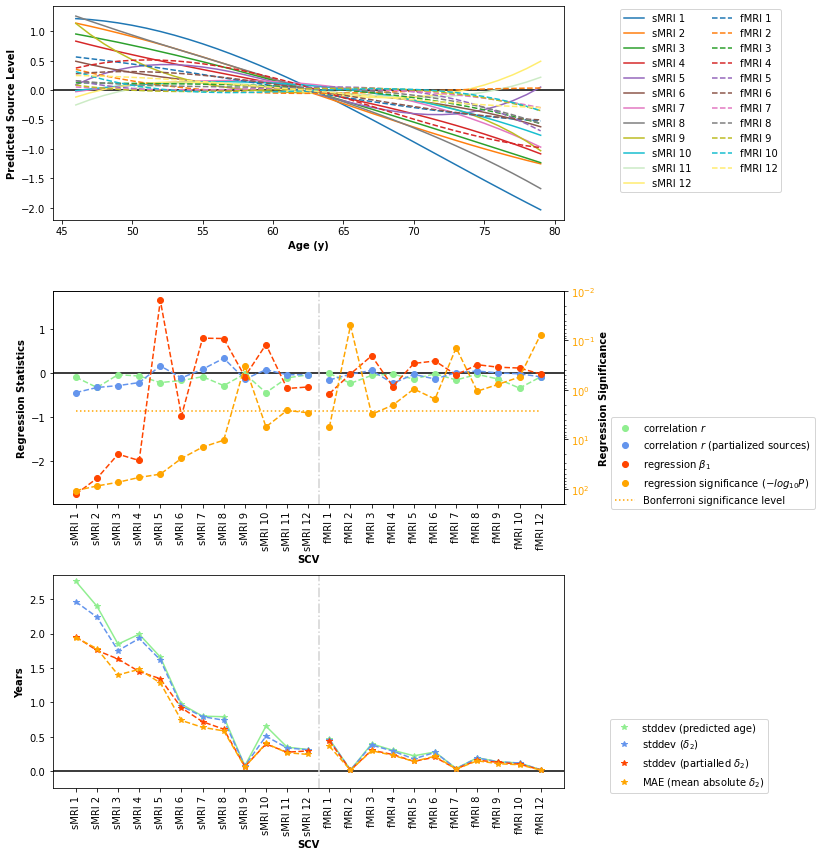

In [11]:
# Fig S1D
# correlation
corr = np.zeros(n_mode)
for i in range(n_mode):
    corr[i] = np.corrcoef(X_new[:, i], Y)[0,1]

corr_nonpartial = np.zeros(n_mode)
for i in range(n_mode):
    corr_nonpartial[i] = np.corrcoef(X_sorted[:, i], Y)[0,1]

xtick_label = []
for i in range(12):
    xtick_label.append(f"sMRI {i+1}")
for i in range(10):
    xtick_label.append(f"fMRI {i+1}")
xtick_label.append(f"fMRI 12")

smri_colors, fmri_colors = [], []
for i in range(10):
    smri_colors.append(sns.color_palette("tab10")[i])
    fmri_colors.append(sns.color_palette("tab10")[i])
smri_colors.append(sns.color_palette("Set3")[-2])
smri_colors.append(sns.color_palette("Set3")[-1])
fmri_colors.append(sns.color_palette("Set3")[-1])

# Fig 1
X_demean = X - np.mean(X, axis=0)
age = np.arange( int(min(Y)), int(max(Y)) )
beta = np.linalg.inv(Y2_new[:, :3].T @ Y2_new[:, :3]) @ Y2_new[:, :3].T @ X_demean
ixa = np.argsort(Y) # Sort raw age

beta_sorted = beta[:,reversed_sorted_index]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(13,12))

ax1.axhline(y=0, linestyle='-', color='black')
for i in range(n_mode):
    if i < 12:
        ax1.plot( Y[ixa], beta_sorted[0,i] * Y2_new[ixa,0] + beta_sorted[1,i] * Y2_new[ixa,1] + beta_sorted[2,i] * Y2_new[ixa,2], label=xtick_label[i], color=smri_colors[i])
    else:
        ax1.plot( Y[ixa], beta_sorted[0,i] * Y2_new[ixa,0] + beta_sorted[1,i] * Y2_new[ixa,1] + beta_sorted[2,i] * Y2_new[ixa,2], '--', label=xtick_label[i], color=fmri_colors[i-12])

# ax1.set_ylim([-2.25, 1.25])
ax1.legend(ncol=2,bbox_to_anchor=(1.1, 1.01))
ax1.set_xlabel('Age (y)', fontweight='bold')
ax1.set_ylabel('Predicted Source Level', fontweight='bold')

# regression significance
ax2.axhline(y=0, linestyle='-', color='black')

# sMRI
ln1 = ax2.plot(range(n_mode), corr_nonpartial, 'o', color='lightgreen', label='correlation $r$')
ax2.plot(range(12), corr_nonpartial[:12], '--', color='lightgreen')
ax2.plot(range(12,n_mode), corr_nonpartial[12:], '--', color='lightgreen')

ln2 = ax2.plot(range(n_mode), corr, 'o', color='cornflowerblue', label='correlation $r$ (partialized sources)')
ax2.plot(range(12), corr[:12], '--', color='cornflowerblue')
ax2.plot(range(12,n_mode), corr[12:], '--', color='cornflowerblue')

ln3 = ax2.plot(range(n_mode), beta1i, 'o', color='orangered', label='regression $\\beta_1$')
ax2.plot(range(12), beta1i[:12], '--', color='orangered')
ax2.plot(range(12,n_mode), beta1i[12:], '--', color='orangered')
ax2.axvline(x=n_mode//2+0.5, linestyle='-.', color='lightgray')
ax2.set_xlabel('SCV', fontweight='bold')
ax2.set_ylabel('Regression Statistics', fontweight='bold')
ax2.set_xticks(range(n_mode))
ax2.set_xticklabels(xtick_label, rotation=90)
# ax2.set_ylim([-2.85, 0.25])

ax22 = ax2.twinx()
ln4 = ax22.plot(range(n_mode), log_p_values, 'o', color='orange', label='regression significance $(-log_{10}P)$')
ax22.plot(range(12), log_p_values[:12], '--', color='orange')
ax22.plot(range(12,n_mode), log_p_values[12:], '--', color='orange')
ax22.set_ylim([10**(-2), 2*10**2])
ln5 = ax22.plot(range(n_mode), np.repeat(-np.log10(0.05/n_mode), n_mode), linestyle=':', color='orange', label='Bonferroni significance level')
ax22.set_yscale('log')

ax22.set_ylabel('Regression Significance', fontweight='bold')
ax22.tick_params(axis='y', labelcolor='orange')
ax22.invert_yaxis()

ln = ln1+ln2+ln3+ln4+ln5
lab = [l.get_label() for l in ln]
ax2.legend(ln, lab, bbox_to_anchor=(1.5, 0.43))

# Fig S1B
delta1i_std = np.std(delta1i, axis=0, ddof=1)
delta2i_std = np.std(delta2i, axis=0, ddof=1)
delta3i_std = np.std(delta3i, axis=0, ddof=1)
predicted_age_std = np.zeros(n_mode)
for i in range(n_mode):
    predicted_age = X_new * beta1i[i]
    predicted_age_std[i] = np.std(predicted_age, ddof=1)

ax3.axhline(y=0, linestyle='-', color='black')
ax3.plot(range(n_mode), predicted_age_std, '*', color='lightgreen', label='stddev (predicted age)')
ax3.plot(range(12), predicted_age_std[:12], color='lightgreen')
ax3.plot(range(12, n_mode), predicted_age_std[12:], color='lightgreen')

ax3.plot(range(n_mode), delta2i_std, '*', color='cornflowerblue', label='stddev ($\delta_2$)')
ax3.plot(range(12), delta2i_std[:12], '--', color='cornflowerblue')
ax3.plot(range(12, n_mode), delta2i_std[12:], '--', color='cornflowerblue')

ax3.plot(range(n_mode), delta3i_std, '*', color='orangered', label='stddev (partialled $\delta_2$)')
ax3.plot(range(12), delta3i_std[:12], '--', color='orangered')
ax3.plot(range(12, n_mode), delta3i_std[12:], '--', color='orangered')

ax3.plot(range(n_mode), delta2i_mae, '*', color='orange', label='MAE (mean absolute $\delta_2$)')
ax3.plot(range(12), delta2i_mae[:12], '--', color='orange')
ax3.plot(range(12, n_mode), delta2i_mae[12:], '--', color='orange')

ax3.axvline(x=n_mode//2+0.5, linestyle='-.', color='lightgray')
ax3.legend(bbox_to_anchor=(1.08, 0.35))
ax3.set_xlabel('SCV', fontweight='bold')
ax3.set_ylabel('Years', fontweight='bold')
ax3.set_xticks(range(n_mode))
ax3.set_xticklabels(xtick_label, rotation=90)
ax3.set_ylim([-0.25, 2.85])

plt.tight_layout()
plt.savefig('brain_age_delta.pdf', dpi=300)